# <div align="center"> 风格迁移 </div>

In [65]:
import os
import re
import json
import numpy as np
import torch
import requests
import base64
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from k12libs.utils.nb_easy import k12ai_get_top_dir, RACEURL


from PIL import Image
from IPython.display import display, HTML

In [47]:
torch.__version__, np.__version__

('1.6.0.dev20200609+cu101', '1.18.5')

In [48]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [49]:
SYTLE_WEIGHT_PATH = '/data/pretrained/cv/fast_neural_style'
!ls $SYTLE_WEIGHT_PATH 

candy.pth  mosaic.pth  rain_princess.pth  udnie.pth


In [50]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = torch.nn.functional.interpolate(x, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvBlock(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvBlock(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True, )
        self.conv2 = ConvBlock(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvBlock(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = ConvBlock(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = ConvBlock(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvBlock(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y
    
# class ResidualBlock(torch.nn.Module):
#     def __init__(self, channels):
#         super(ResidualBlock, self).__init__()
#         self.block = torch.nn.Sequential(
#             ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
#             ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
#         )
# 
#     def forward(self, x):
#         return self.block(x) + x
# 
# class ConvBlock(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
#         super(ConvBlock, self).__init__()
#         self.upsample = upsample
#         self.block = torch.nn.Sequential(
#             torch.nn.ReflectionPad2d(kernel_size // 2),
#             torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
#         )
#         self.norm = torch.nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
#         self.relu = relu
# 
#     def forward(self, x):
#         if self.upsample:
#             x = F.interpolate(x, scale_factor=2)
#         x = self.block(x)
#         if self.norm is not None:
#             x = self.norm(x)
#         if self.relu:
#             x = F.relu(x)
#         return x
#     
# class TransformerNet(torch.nn.Module):
#     def __init__(self):
#         super(TransformerNet, self).__init__()
#         self.model = torch.nn.Sequential(
#             ConvBlock(3, 32, kernel_size=9, stride=1),
#             ConvBlock(32, 64, kernel_size=3, stride=2),
#             ConvBlock(64, 128, kernel_size=3, stride=2),
#             ResidualBlock(128),
#             ResidualBlock(128),
#             ResidualBlock(128),
#             ResidualBlock(128),
#             ResidualBlock(128),
#             ConvBlock(128, 64, kernel_size=3, upsample=True),
#             ConvBlock(64, 32, kernel_size=3, upsample=True),
#             ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
#         )
# 
#     def forward(self, x):
#         return self.model(x)

## Eval

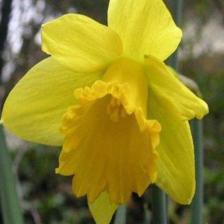

In [51]:
filename = '/data/datasets/cv/rflowers/imgs/1/image_0026.jpg'
content_image = Image.open(filename).convert('RGB')
content_image 

In [52]:
device = torch.device("cuda")

content_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

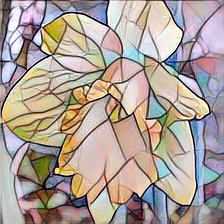

In [53]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load(os.path.join(SYTLE_WEIGHT_PATH, 'mosaic.pth'))
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)
    output = style_model(content_image).cpu()
    
img = output[0].clone().clamp(0, 255).numpy()
img = img.transpose(1, 2, 0).astype("uint8")
img = Image.fromarray(img)
img

## Video

In [54]:
!pip3 install sk-video --trusted-host pypi.tuna.tsinghua.edu.cn --index-url https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [55]:
!pip3 install av --trusted-host pypi.tuna.tsinghua.edu.cn --index-url https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 36.9 MB 1.4 MB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [56]:
from k12libs.utils.nb_easy import k12ai_get_top_dir

import skvideo.io
import av
import tqdm
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
video_path = os.path.join(k12ai_get_top_dir(), 'assets/videos', 'conan_obrien.mp4')
!ls $video_path

In [ ]:
def extract_frames(video_path):
    video = av.open(video_path)
    for frame in video.decode(0):
        yield frame.to_image()

In [ ]:
style_model = TransformerNet()

state_dict = torch.load(os.path.join(SYTLE_WEIGHT_PATH, 'mosaic.pth'))
for k in list(state_dict.keys()):
    if re.search(r'in\d+\.running_(mean|var)$', k):
        del state_dict[k]
style_model.load_state_dict(state_dict)
style_model.to(device)
style_model.eval()

In [ ]:
stylized_frames = []
with torch.no_grad():
    for frame in tqdm.tqdm(extract_frames(video_path), desc="Processing frames"):
        image = content_transform(frame)
        image = image.unsqueeze(0).to(device)
        img = style_model(image).cpu()
        img = img[0].clone().clamp(0, 255).numpy()
        img = img.transpose(1, 2, 0).astype("uint8")
        img = Image.fromarray(img).resize((720, 480))
        stylized_frames.append(img)

In [ ]:
filename_gif = '/data/style.gif'
filename_mp4 = '/data/style.mp4'

In [ ]:
writer = skvideo.io.FFmpegWriter(filename_mp4, outputdict={'-vcodec': 'libx264'})
for frame in tqdm.tqdm(stylized_frames, desc="Writing to video"):
    writer.writeFrame(frame)
writer.close()

In [ ]:
writer = cv2.VideoWriter(filename_mp4, cv2.VideoWriter_fourcc(*"mp4v"), fps=5)
for frame in frames:
    writer.write(frame)
writer.release()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(filename_gif)
plt.imshow(img)
# display.Image(filename=filename, embed=False)

----------------

In [59]:
def img2b64(path):
    with open(path, 'rb') as fr:
        b4data = base64.b64encode(fr.read()).decode()
    return b4data

reqdata = '''{
    "task": "nst.inference",
    "cfg": {
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "%s",
                "dataset": {
                    "class_name": "raceai.data.PredictSingleImageRaw",
                    "params": {}
                 },
             }
        },
        "model": {
            "class_name": f"raceai.models.nftnet.NFTNet",  
            "params": {
                "device": "cuda",
                "weights": "/raceai/data/ckpts/fast_neural_style/mosaic.pth"
            }
        },
    }
}''' % img2b64(filename)

print(reqdata)

{
    "task": "nst.inference",
    "cfg": {
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADgAOADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oA

In [67]:
API_INFERENCE = f'{RACEURL}/raceai/framework/inference'

In [71]:
cfg = eval(reqdata)
resdata = json.loads(requests.post(url=API_INFERENCE, json=cfg).text)
resdata 

{'errno': 0,
 'result': {'b64img': 'iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AAEAAElEQVR4nGz8V7SlR3Xvgc5KX1457Jy6d+/OOSjnBAiEAJPBNmAwBgfsYx9HHA4H7HNwwJgcfEwUBoSEhCwUUA6tVrc6593dO6eV1/pypfsg34c7xq1RD1WPNca/Zs3wq4m++o9/loRw5LVTMuC9TnjFn5OUap1ijOKe2Vqcuf76uzfu2p0fEVlcMJSZ4l6SxnEchn4S+b0gTIQUlml4TsbLeF4+k7FzJnUIYfONRSWU7qadkJ85f+LC5TNguIDlYLFcdIvASCgSJVzDZEvdmaMnTuA4uHn3nd14JSW+i/Nm1slmCoPZ/pQHnCAiSRx0muFiL42JtnTCtVZCJRQoUQYh1DPMTCbfX+0fLvb15crZXCEE3e41hNCpomHkc5HEiajVlxyXElBB3ImSRHAtJJcgEcFBEkWp4AIpTQijtpOpVgdK5SGFTdtmlILWAU6V30hOXry4OlsLaistWA46CUD6sT/+s3vecVs23w4XrF7YYyXlGWXBA5WGPEzanXYYdbXQIkKIpYVCNmgm5y+eHR6coAaYGeAS+35AlGSmk8tlCSCikdKpgoRiKrUKUz/uCJ5ow6UrzcbPH/3xaHF8cbVVHTL6WdGH1MxYIuaeY2BCTcNIo6QZ+kgzSxaWO/Hl+lzPj3jK333nezdX+4+vXQijSskY7OjlUHGMiN/z/bAdqyhNE2awcqEv5zj5nM2j+OLp4w7NYhMKRWQL07BtDVJJFcURYRQZlgJQUgHGFAFBiIAmCLSmEiNqm9gyMTWlQg6zbSAWaKaAKow00ghJzjnXKiEUYbecy2aNnOfZ2QGCzJml5VoQUhprKYgJpmtnCjqf6khhICBMYmtS7MaZ/QP7r526efueibI9oCLQINOUp2mMOEZCSY20Fp7pmbYJFoAEEKA0pAhqnbZHnaBT


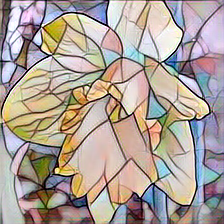

In [72]:
HTML(data='<img src="data:image/png;base64,{}"/>'.format(resdata['result']['b64img']))

## References

1. https://github.com/pytorch/examples/tree/master/fast_neural_style